In [2]:
# 对数据源X（美国选举数据集）， 对不同的预处理方案中建立不同的模型，最终汇总所有模型的结果
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

SEED = 222
np.random.seed(SEED)

df = pd.read_csv('./sample_data/input.csv')

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# 在本文中，我们将使用美国政治捐款数据集来解释集成的工作原理。该数据集最初由 FiveThirtyEight 的 Ben Wieder 制作，他查阅美国政府的政治捐款记录，发现科学家向政治家们捐款时，通常会选择民主党。
# 该论断基于向共和党和民主党捐款数额的比例。但是，我们还可以从中看出更多事情：比如，哪个学科最可能捐款给共和党，哪个州最可能捐款给民主党。我们将更进一步，预测捐款更可能的流向。
# 此处使用的数据经过稍微修改(https://www.dataquest.io/blog/large_files/input.csv)。我们删除了捐款给共和党和民主党之外的其他党派的捐款信息，以使过程更加清晰，并且还去除了重复信息和不太有趣的特征。数据脚本地址：https://www.dataquest.io/blog/large_files/gen_data.py
def get_train_test(test_size = 0.2):
  y = 1 * (df.cand_pty_affiliation == 'REP')
  # print(y)
  X = df.drop(['cand_pty_affiliation'], axis = 1)  # 去掉标签这一列，得到x
  # print(X)
  # pandas提供对one-hot编码的函数是get_dummies()
  X = pd.get_dummies(X, sparse = True)
  X.drop(X.columns[X.std() == 0], axis=1, inplace=True)  #将标准差为0（意味着该列每一个值都一样）的列删除
  return train_test_split(X, y, test_size = test_size, random_state=SEED)

xtrain, xtest, ytrain, ytest = get_train_test()
# get_train_test()
print("\n样本数据：")
df.head()




样本数据：


,cand_pty_affiliation,cand_office_st,cand_office,cand_status,rpt_tp,transaction_tp,entity_tp,state,classification,cycle,transaction_amt
0,REP,US,P,C,Q3,15,IND,NY,Engineer,2016.0,500.0
1,DEM,US,P,C,M5,15E,IND,OR,Math-Stat,2016.0,50.0
2,DEM,US,P,C,M3,15,IND,TX,Scientist,2008.0,250.0
3,DEM,US,P,C,Q2,15E,IND,IN,Math-Stat,2016.0,250.0
4,REP,US,P,C,12G,15,IND,MA,Engineer,2016.0,184.0


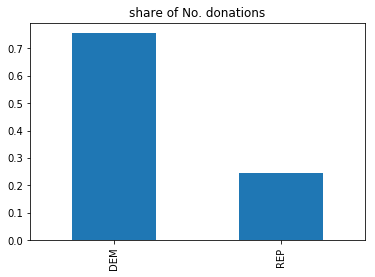

In [3]:
# normalize=True时,可计算出不同字符出现的频率.
df.cand_pty_affiliation.value_counts(normalize=True).plot(
    kind='bar', title="share of No. donations"
) 
# 画出民主党和共和党人数占比
plt.show()

Decision tree ROC-AUC score: 0.673


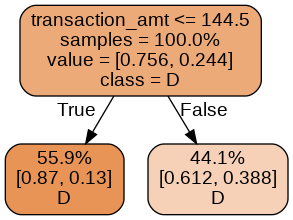

In [4]:
# 构建几个基础的决策树模型
import pydotplus
from IPython.display import Image
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

def print_graph(clf, feature_names):
  graph = export_graphviz(
      clf,
      label="root",
      proportion=True,
      impurity = False,
      out_file = None,
      feature_names = feature_names,
      class_names = {0:"D", 1:"R"},
      filled=True,
      rounded=True
  )
  graph = pydotplus.graph_from_dot_data(graph)
  return Image(graph.create_png())

t1 = DecisionTreeClassifier(max_depth=1, random_state=SEED)
t1.fit(xtrain, ytrain)
p = t1.predict_proba(xtest)[:, 1]
print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t1, xtrain.columns)

Decision tree ROC-AUC score: 0.804


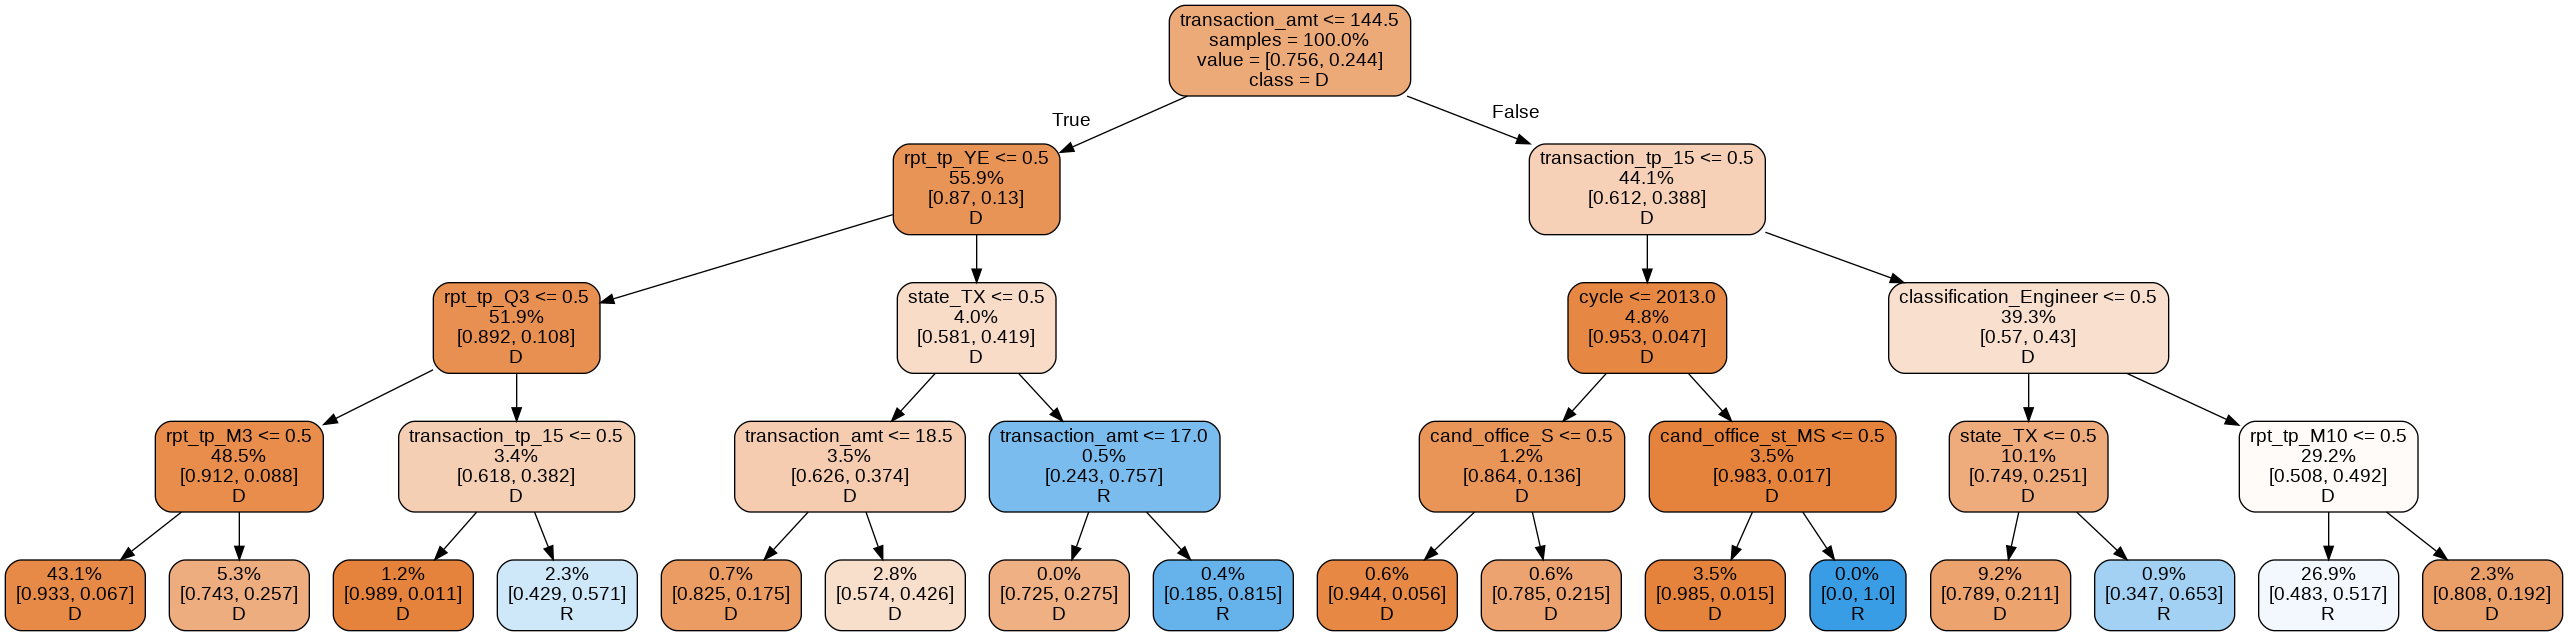

In [5]:
t2 = DecisionTreeClassifier(max_depth=4, random_state=SEED)
t2.fit(xtrain, ytrain)
p = t2.predict_proba(xtest)[:, 1]
print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t2, xtrain.columns)

Decision tree ROC-AUC score: 0.783


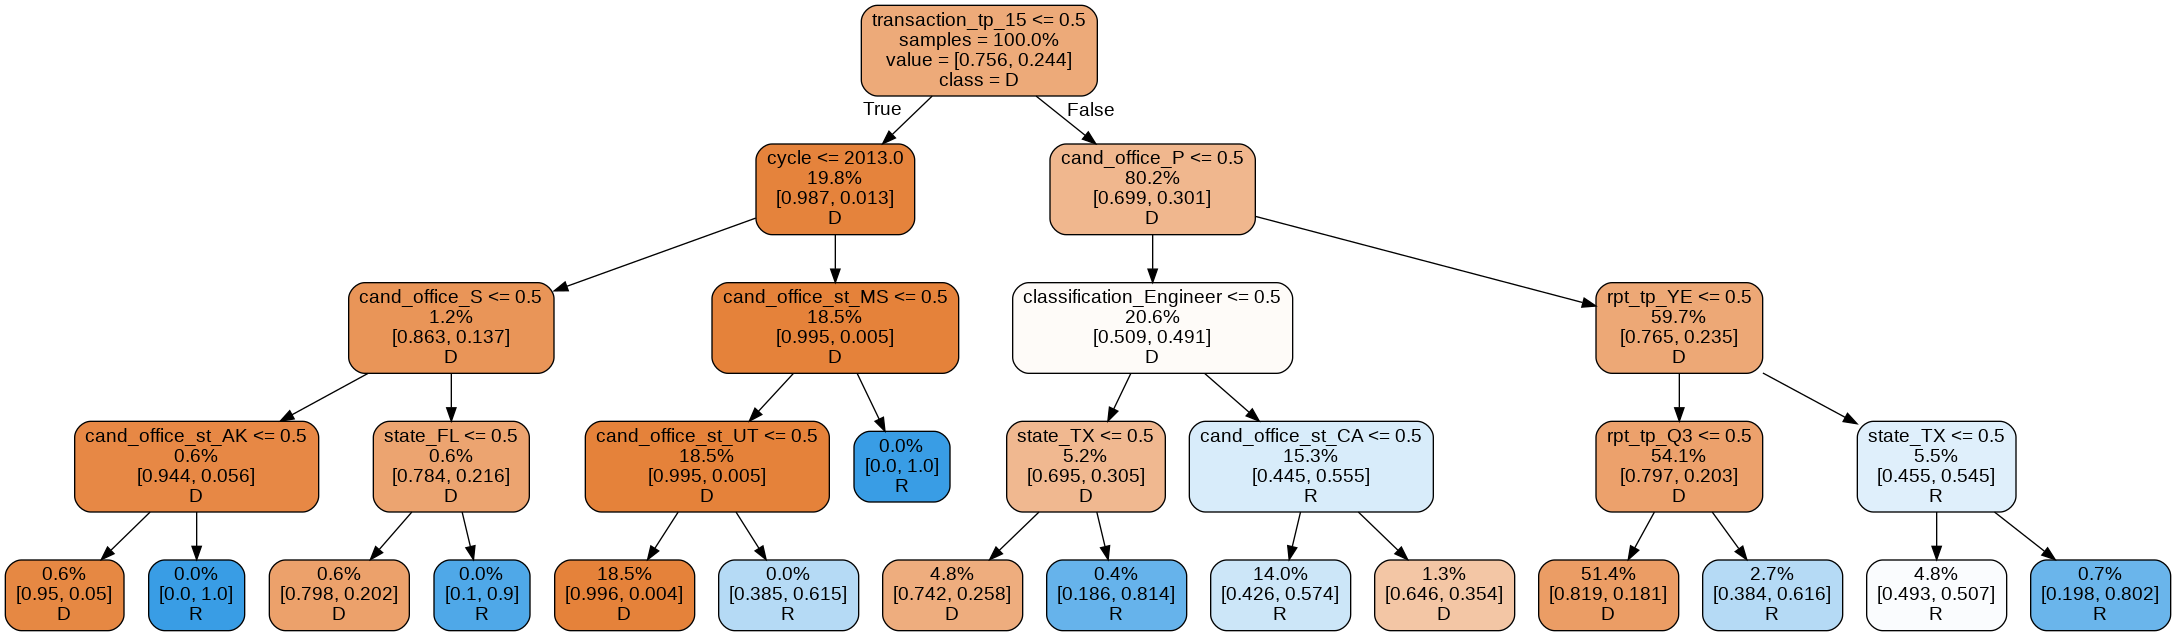

In [6]:
# 43.1%的样本落到了最左边， 还有26.9%的样本落到了最右边，看起来模型基本是过拟合
# 调整策略，去掉对结果有最大影响的因素
drop = ['transaction_amt']

xtrain_slim = xtrain.drop(drop, 1)
xtest_slim = xtest.drop(drop, 1)
# print(ytest)
t3 = DecisionTreeClassifier(max_depth=4, random_state=SEED)
t3.fit(xtrain_slim, ytrain)
p = t3.predict_proba(xtest_slim)[:,1]
# print(p)
print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t3, xtrain_slim.columns)

In [7]:
p2 = t2.predict_proba(xtest)[:,1]
p3 = t3.predict_proba(xtest_slim)[:,1]
# 简单将2棵树的结果球平均
p = np.mean([p2, p3], axis=0)
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Average of decision tree ROC-AUC score: 0.835


In [8]:
# 应该选择不同的特征，对产生的不同结果进行组合
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators = 10,
    max_features = 3,
    random_state = SEED
)
rf.fit(xtrain, ytrain)
p = rf.predict_proba(xtest)[:, 1]
print("Average of decision tree ROC-AUC score : %.3f" % roc_auc_score(ytest, p))

Average of decision tree ROC-AUC score : 0.891


In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline

def get_models():
  """生成基本学习器"""
  nb = GaussianNB()   # 高斯贝叶斯分类器gaussianNB
  # C越大，相当于惩罚松弛变量，希望松弛变量接近0，即对误分类的惩罚增大，趋向于对训练集全分对的情况，
  # 这样对训练集测试时准确率很高，但泛化能力弱
  svc = SVC(C=100, probability=True) # 采用概率估计
  knn = KNeighborsClassifier(n_neighbors=3)
  lr = LogisticRegression(C=100, random_state=SEED)
  nn = MLPClassifier((80,10), early_stopping=False, random_state=SEED)
  gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
  rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)


  models = {
      # "svm":svc,
      "knn":knn,
      "naive-bayes":nb,
      "mlp-nn":nn,
      "random_forest":rf,
      "gdm":gb,
      "logistic":lr
  }
  return models

import numpy as np
def train_predict(model_list):
  # fit model in list on training set and return preds
  P = np.zeros((ytest.shape[0], len(model_list)))
  P = pd.DataFrame(P)

  print("Fiting modls.")
  cols = list()
  for i, (name, m) in enumerate(model_list.items()):
    print("%s..." % name, end=" ", flush=False)
    m.fit(xtrain, ytrain)
    P.iloc[:, i] = m.predict_proba(xtest)[:,1]
    cols.append(name)
    print("done")
  P.columns = cols
  print("Done.\n")
  return P

def score_models(P, y):
  # """Score model in prediction DF"""
  print("Scoring models.")
  for m in P.columns:
    score = roc_auc_score(y, P.loc[:, m])
    print("%-26s: %.3f" % (m, score))
  print("Done.\n")

models = get_models()
P = train_predict(models)
score_models(P, ytest)

Fiting modls.
random_forest... done
Done.

Scoring models.
random_forest             : 0.891
Done.



In [0]:
# from mlens.visualization import corrmat

# # 看不同模型之间的相关程度
# corrmat(P.corr(), inflate=False)
# plt.show()
# print("Ensemble ROC-AUC score :%.3f" % roc_auc_score(ytest, P.mean(axis=1)))

[0.         0.0109192  0.0109192  ... 0.37370128 0.37383363 1.        ] 

[0.         0.17733688 0.17754142 ... 0.94866026 0.94866026 1.        ] 

-------------------------------------


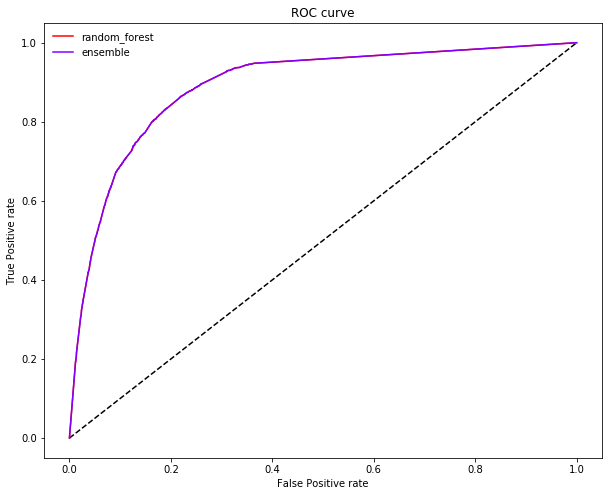

In [11]:
# 集成算法一方面使得边界更加平稳，一方面使得效果更好
from sklearn.metrics import roc_curve

def plot_roc_curve(ytest, P_base_learners, P_ensemble, labels, ens_label):
  # 为基本学习器和集成学习学习器绘制roc曲线
  plt.figure(figsize = (10, 8))
  plt.plot([0,1], [0,1], 'k--')

  cm = [plt.cm.rainbow(i) for i in np.linspace(0, 1.0, P_base_learners.shape[1]+1)]
  for i in range(P_base_learners.shape[1]):
    p = P_base_learners[:, i]
    # 假正率和真正率
    fpr, tpr, _ = roc_curve(ytest, p)
    print(fpr, "\n")
    print(tpr, "\n")
    print("-------------------------------------")
    plt.plot(fpr, tpr, label=labels[i], c=cm[i+1])
  
  fpr, tpr, _ = roc_curve(ytest, P_ensemble)
  plt.plot(fpr, tpr, label=ens_label, c=cm[0])

  plt.xlabel("False Positive rate")
  plt.ylabel("True Positive rate")
  plt.title("ROC curve")
  plt.legend(frameon=False)
  plt.show()

plot_roc_curve(ytest, P.values, P.mean(axis=1), list(P.columns), "ensemble")



Text(0, 0.23, 'True share republicans')

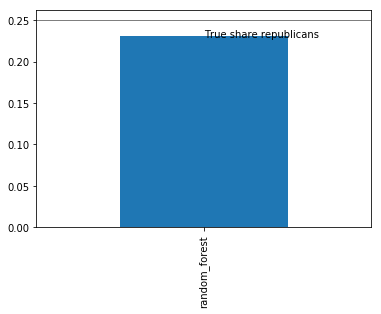

In [12]:
# 上述集成学习算法只是平均各个基学习器的结果，并不公平
# stacking
# print(P)
# 画出各模型共和党的预测结果
p = P.apply(lambda x: 1*(x >= 0.5).value_counts(normalize=True))  # normalize=True进行标准化
p.index = ["DEN", "REP"]
p.loc["REP",:].sort_values().plot(kind="bar")
plt.axhline(0.25, color="k", linewidth=0.5)
# 真正的共和党人
plt.text(0, 0.23, "True share republicans")


In [13]:
# 清除结果最差的模型
include = [c for c in P.columns if c not in ["gbm"]]
# 之前是0.891
print("Truncated ensemble ROC-AUC socre: %.3f " % roc_auc_score(ytest, P.loc[:, include].mean(axis=1)))

Truncated ensemble ROC-AUC socre: 0.891 


In [14]:
# 为避免手工挑选基础模型，得指定标准让机器继续选择
# 如，给每个基础模型一个权重，然后对 就是stacking

# 1、定义基础模型
base_learners = get_models()

# 2、定义权重分配模型
meta_learner = GradientBoostingClassifier(
    n_estimators = 1000,
    loss = "exponential", # 指数损失
    max_features = 4,
    max_depth = 3,
    subsample = 0.5,
    learning_rate = 0.005,
    random_state = SEED
)

# 3、将基础模型分为两个部分，主要供第二层使用
xtrain_base, xpred_base, ytrain_base, ypred_base = train_test_split(
    xtrain, ytrain, test_size=0.5, random_state=SEED)

# print(xtrain_base.head)
print(xtrain_base.isnull().values.any())
# 将所有nan替换为0
xtrain_base = xtrain_base.fillna(0)
print(xtrain_base.isnull().values.any())
# print(ytrain_base.isnull().values.any())


# 4、训练基础模型
def train_base_learners(base_learners, inp, out, verbose=True):
  if verbose: print("Fitting modls.")
  for i, (name, m) in enumerate(base_learners.items()):
    if verbose: print("%s..." % name, end=" ", flush=False)
    m.fit(inp, out)
    if verbose: print("done")

train_base_learners(base_learners, xtrain_base, ytrain_base)
# 二阶段的输入数据是一阶段没有看过的：一阶段预测的结果作为二阶段的输入

# 5、准备二阶段权重分配分类器的训练数据
def predict_base_learners(pred_base_learners, inp, verbose=True):
  # 生成一个预测矩阵
  P = np.zeros((inp.shape[0], len(pred_base_learners)))

  if verbose: print("Generating base learner predictions.")
  for i, (name, m) in enumerate(pred_base_learners.items()):
    if verbose: print("%s..." % name, end=" ", flush=False)
    p = m.predict_proba(inp)
    P[:, i] = p[:, 1]
    if verbose: print("done")
  return P

xpred_base = xpred_base.fillna(0)
P_base = predict_base_learners(base_learners, xpred_base)
P_base.shape
P_base[0]

# 6、训练二阶段得出分类结果
meta_learner.fit(P_base, ypred_base)

def ensemble_predict(base_learners, meta_learner, inp, verbose=True):
  # 生成集成预测
  P_pred = predict_base_learners(base_learners, inp, verbose=verbose)
  return P_pred, meta_learner.predict_proba(P_pred)[:,1]  # 返回两个阶段的预测结果

P_pred, p = ensemble_predict(base_learners, meta_learner, xtest)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

True
False
Fitting modls.
random_forest... done
Generating base learner predictions.
random_forest... done


ValueError: ignored

In [15]:
from sklearn.base import clone
# 划分为训练集和测试集虽然满足需求，但是好像损失了一部分数据
# 使用交叉验证解决
def stacking(base_learners, meta_learner, X, y, generator):
  print("Fitting final base learners...", end="")
  train_base_learners(base_learners, X, y, verbose=False)
  print("done")
  print("Generating cross-validated predictions...")
  cv_preds, cv_y = [], []
  for i, (train_idx, test_idx) in enumerate(generator.split(X)):
    fold_xtrain, fold_ytrain = X[train_idx, :], y[train_idx]
    fold_xtest, fold_ytest = X[test_idx,:], y[test_idx]

    fold_base_learners = {name: clone(model) for name, model in base_learners.items()}
    fold_P_base = predict_base_learners(
       fold_base_learners, fold_xtest, verbose=False 
    )
    cv_preds.append(fold_P_base)
    cv_y.append(fold_ytest)
    print("Fold %i done" % (i+1))
  print("CV_predictions done")

  # 按照垂直方向形成一个新的数组
  cv_preds = np.vstack(cv_preds)
  # 按照水平方向形成一个新的数组
  cv_y = np.hstack(cv_y)

  meta_learner.fit(cv_preds, cv_y)
  print("done")

  return base_learners, meta_learner


from sklearn.model_selection import KFold
cy_base_learners, cv_meta_learner = stacking(
    get_models(), clone(meta_learner), xtrain.values, ytrain.values, KFold(2)
)

P_pred, p = ensemble_predict(cv_base_learners, cv_meta_learner, xtest, verbose=False)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest, p))


Fitting final base learners...done
Generating cross-validated predictions...


NotFittedError: ignored

In [0]:
# 并行执行
from mlens.ensemble import SuperLearner

s1 = SuperLearner(
    folds=10,
    random_state=SEED,
    verbose = 2,
    backend = "multiprocessing"
)

s1.add(list(base_learners.values()),proba=True)
s1.add_meta(meta_learner, proba=True)

s1.fit(xtrain, ytrain)

p_s1 = s1.predict_proba(xtest)
print("\nSuper Learner ROC-AUC score: %.3f" %roc_auc_score(ytest, p_s1[:,1]))

plot_roc_curve(ytest, p.reshape(-1, 1), P.mean(axis=1), ["Simple average"], "Super Learner")